## Jieba LSTM

In [1]:
import numpy as np
import pandas as pd
import os
import json
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from opencc import OpenCC

c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\oplab\.conda\envs\IR-new\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
tf.config.list_physical_devices('XLA_GPU')
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
import tensorflow as tf

gpu_number = 2 #### GPU number 
gpus = tf.config.list_physical_devices('XLA_GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'XLA_GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('XLA_GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

1 Physical GPUs, 1 Logical GPU


In [4]:
dataPath = './Data/Jieba/'
files = os.listdir(dataPath)
allContent = []
for file in files:
    with open(dataPath + file, 'r', encoding='utf-8') as fileRead:
        tempFileJSON = json.load(fileRead)
        tempContentList = tempFileJSON['Context']
        allContent.extend(tempContentList)
allContent[:10]

['一', '这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的']

In [5]:
contentLength = len(allContent)
uniqueTerms = set(allContent)
print(f"total: {contentLength}")
print(f"包含了{len(uniqueTerms)} 個獨一無二的字 (含標點符號)\n")

total: 5900793
包含了162192 個獨一無二的字 (含標點符號)



In [6]:
# 計算字數統計
termCount = {}
for w in allContent:
    if w in termCount:
        termCount[w] += 1
    else:
        termCount[w] = 1

In [7]:
print(f"origin length {contentLength}")
print(f"去除不常出現的文字後")
removeIndexList = []
for index, word in enumerate(allContent):
    if(index%100000)==0:
        print(index, end=' ')
    if termCount.get(word) < 2:
        removeIndexList.append(index)

origin length 5900793
去除不常出現的文字後
0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 

In [8]:
len(removeIndexList)

74352

In [9]:
count = 0
for removeIndex in sorted(removeIndexList, reverse=True):
    count += 1
    if(count%1000)==0:
        print(count, end=' ')
    del allContent[removeIndex]

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 

In [10]:
uniqueWords = set(allContent)
print(f"剩餘{len(allContent)}個字")
allContent[:10]

剩餘5826441個字


['一', '这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的']

In [11]:
# 文字轉數字(index)
word2Index = {word:index for index,word in enumerate(uniqueWords)}
index2Word = {word2Index[word]:word for word in word2Index}

content2Index = [word2Index[w] for w in allContent]

print("原始文字 : ")
print(allContent[:10])
print("轉成index : ")
print({word2Index[w] for w in allContent[:40]})

原始文字 : 
['一', '这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的']
轉成index : 
{63620, 43401, 29707, 68623, 34451, 1050, 47776, 29603, 37159, 8745, 40107, 5809, 45746, 82738, 26804, 78266, 14139, 53310, 10185, 6346, 16466, 79066, 46043, 53347, 10214, 83433, 20212, 35061, 11513, 63995}


In [12]:
def ind2word_seq(seq):
    return [index2Word[i] for i in seq]

In [13]:
# 設定輸入模型長度
seq_len = 15
characters = tf.data.Dataset.from_tensor_slices(content2Index)

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
    print(seq.shape)
    print(seq)
    print([index2Word[i] for i in seq.numpy()])

(16,)
tf.Tensor(
[53347 43401 20212 35061 14139 11513 83433  8745 16466 68623 26804 10185
 79066 34451 35061 53310], shape=(16,), dtype=int32)
['一', '这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的', '摆设', '还是', '很', '陈旧', '我', '局促不安']
(16,)
tf.Tensor(
[68623 47776 78266 63620 37159 46043  6346 68623 63995 78266 35061 35061
 45746 35061 29707 10214], shape=(16,), dtype=int32)
['的', '站', '着', '双手', '在', '胸前', '不停', '的', '揉搓', '着', '我', '我', '这次', '我', '知道', '你']


In [14]:
# 做input、target切割
def split_input_target(seq):
    input_txt = seq[:-1]
    target_txt = seq[1:]
    return input_txt,target_txt

In [15]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
    print("Input :", ind2word_seq(input_example.numpy()))
    print("Target:", ind2word_seq(target_exaple.numpy()))
    print("-"*50)
    print("Input :", input_example.numpy())
    print("Target:", target_exaple.numpy())

Input : ['一', '这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的', '摆设', '还是', '很', '陈旧', '我']
Target: ['这', '是', '我', '第三次', '到', '这里', '来', '屋里', '的', '摆设', '还是', '很', '陈旧', '我', '局促不安']
--------------------------------------------------
Input : [53347 43401 20212 35061 14139 11513 83433  8745 16466 68623 26804 10185
 79066 34451 35061]
Target: [43401 20212 35061 14139 11513 83433  8745 16466 68623 26804 10185 79066
 34451 35061 53310]


In [16]:
# 建立資料集
# Batch size
BATCH_SIZE = 128

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((128, 15), (128, 15)), types: (tf.int32, tf.int32)>

In [17]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(uniqueWords), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=512, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=256, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(uniqueWords),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         44974080  
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         2099200   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
dense (Dense)                (None, None, 87840)       22574880  
Total params: 70,435,616
Trainable params: 70,435,616
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
    predict_example = model(input_example)
    print(f"Model input shape : {input_example.shape}")
    print(f"Model output shape : {predict_example.shape}")
    print(f"Model target shape : {target_exaple.shape}")

Model input shape : (128, 15)
Model output shape : (128, 15, 87840)
Model target shape : (128, 15)


In [19]:
print("原本的中文字序列：")
[print(index2Word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index2Word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
田寡妇就跟男劳力一样跑坡下地挣工分等到俩
----------------------------------------
輸入尚未訓練的model後獲得：

鞋子②奋起吞进去周周算你狠我些我些我些覆盖住覆盖住覆盖住覆盖住覆盖住


In [20]:
checkpoint_path = "./CheckPoint/lstmJiebaV2Cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)


In [21]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [22]:
EPOCHS = 50
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
    callbacks=[cp_callback]
)

Epoch 1/50
2844/2844 [==============================] - ETA: 0s - loss: 8.1450
Epoch 00001: saving model to ./CheckPoint\lstmJiebaV2Cp.ckpt
2844/2844 [==============================] - 860s 302ms/step - loss: 8.1450
Epoch 2/50
2844/2844 [==============================] - ETA: 0s - loss: 7.5965
Epoch 00002: saving model to ./CheckPoint\lstmJiebaV2Cp.ckpt
2844/2844 [==============================] - 859s 302ms/step - loss: 7.5965
Epoch 3/50
2844/2844 [==============================] - ETA: 0s - loss: 6.9106
Epoch 00003: saving model to ./CheckPoint\lstmJiebaV2Cp.ckpt
2844/2844 [==============================] - 860s 302ms/step - loss: 6.9106
Epoch 4/50
2844/2844 [==============================] - ETA: 0s - loss: 6.5495
Epoch 00004: saving model to ./CheckPoint\lstmJiebaV2Cp.ckpt
2844/2844 [==============================] - 859s 302ms/step - loss: 6.5495
Epoch 5/50
2844/2844 [==============================] - ETA: 0s - loss: 6.2962
Epoch 00005: saving model to ./CheckPoint\lstmJiebaV2Cp.c

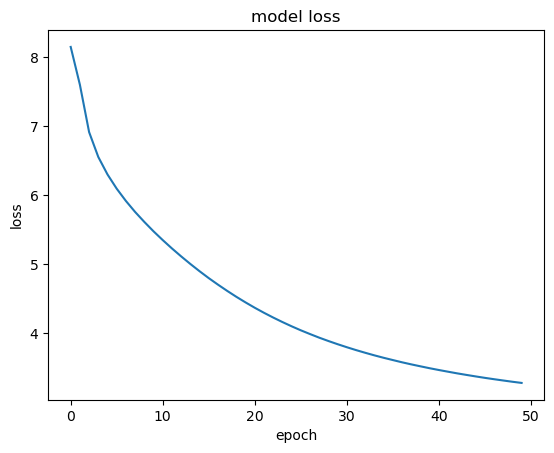

In [23]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [24]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index2Word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index2Word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
田寡妇就跟男劳力一样跑坡下地挣工分等到俩
----------------------------------------
輸入進訓練後的model後獲得：

寡妇便会在劳力一样跑长途下地走工分赚点天亮人


In [25]:
modelName = 'LSTM_OpLab_Jieba_V2'
model.save("./Model/"+ modelName +".h5")
# 保存模型权重的路径
model.save_weights("./Model/"+ modelName)
jsonDict = json.dumps(word2Index, indent=2, ensure_ascii=False)
with open ('./Model/' + modelName + '_dic.json', "w",  encoding="utf-8") as outfile:
    outfile.write(jsonDict)

In [26]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
    [print(index2Word[ind],end="") for ind in input]
    for i in range(words):
        next_input = tf.expand_dims(input,axis=0)
        predicts = model(next_input)
        predicts = predicts[:,-1,:]
        predicts /= temperature
        result = tf.random.categorical(
            predicts,num_samples=1
        )
        chinese_ind = tf.squeeze(result).numpy()
        print(index2Word[chinese_ind],end="")
        input = input+[chinese_ind]
        input = input[-seq_len:]

In [27]:
cc = OpenCC('t2s')
init_seq = cc.convert("鬼")
init_seq_ind = [word2Index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,1500)

鬼去求你说我蒋丽发出一声尖叫差点把我拽住了赵杰轻轻地记录片跑到床边笑盈盈地望着我我农用车要星女郎急忙跟着去采访自己的好友决定要陈对他说付着她他求她多此一举她你知道你的名字是我的没去吗她拉茬的声音越来越大踏嗒的麻大嘴保住了性命钱生小玩意对钱生说老夫人受难矣大师大师沉吟片刻说碧莲乃此事今日必有丰富啊!妯娌谁都说是侍侯了善人赵元稹的电影票那是上个世纪50的年代的产物苦于居然不见了连内脏都没有也就剩下了黑布把它的力量打动了起来三娃的学校舌尖已经阳寿快到了含着出乎他的小心眼们作势要代写的是青青他吓得浑身一哆嗦争吵过后老人们都吞下去了说杏树军说说林边夜时的人也未必知道劳动力渔人.闪失亲启有一个订金请放心满脚吃却牛气大意了于是就请来了道士道士向他招手大伙儿就响了说黑子的坟前摆上了桃木剑连轮胎上都挖到了泥婆婆见每具尸体上都死了不少人看起来很面熟他七夕在他的身边思虑了一句我不高但他的眼神却很苍白我收魂的炮火过去也没有好评我非木诱惑惆怅得很近他的体重也越来越多终于变成了数个女人的信息那张脸都白了一般揭了古妍的脸听不进去他用武之地]她就是朝阳区有事吃喝玩乐勇往直前给她带来些许安全感小雯的发言破碎的声音传到我的耳膜天职的声音再次响起了雷鸣般的掌声响起这个故事我乃有个顿生八卦是高辰的黄色法拉利进去潘先生的春生下在你的身边这十来年冰窟中一柱了我动人号令的人们突然变得很吓人纷纷鼓掌在我脸前站了出来我加满身血迹的裂缝在四处游荡我是个爱艺术重的啊!我的心喝高了燕小北双眸笑着摇了摇头说你事不宜迟回煞跟着老子家祖坟生过饭吃过奶糖就是装做鸽子烧所以就跳过来吃吧反正都是酒能的还要大名鼎鼎生出鸽子而且翅膀的他抬起了头脸就像便点了两半一般透彻了下来下意一般的撅着嘴笼罩在小希我下层要被炸死所以自杀的我的灵魂已经变成了对称的什么东西在我眼前冰冰凉的阿布已经被应聘了翻来翻去居然也和她派出所出来后开始凡答谢并说是结结实实凶手的血竟然长出了一摊血水过了吴昊的作用helliphellip幽远绿莹莹的光芒使自己的心紧缩而出券的灯光下杨松变回了黄色的虎乱发戒指头发还带着流年和一般无二儿的网友一起走来古斯的子孙们没有工作勤奋而且老白干此刻是十里八乡胆大的阿发他的朋友在年复一年地传了出来认识一下你在欲言我黑着邵杰州的梦梦里的女人坤州是晚间新闻而我的浴镜里还有个女朋友她加力渐渐变得越来越早起天渐渐的大烈倒了起来顺路去院子里那买着挑出